In [1]:
#Import Library
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [2]:
#global variable
NUM_WORDS = 1000
OOV_TOKEN = "<OOV>"
PADDING = 'post'
MAXLEN = 120
EMBEDDING_DIM = 16

In [3]:
#Retrieve DS from Github
dataset_link = 'https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv'
response = requests.get(dataset_link)

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv')
# Identify Unnamed columns
unnamed_columns = [col for col in data.columns if 'Unnamed' in col]

# Drop Unnamed columns
data = data.drop(unnamed_columns, axis=1)
#shuffle data
data = data.sample(frac=1)

print(data.head())
print("\n")
print(data.tail())

       Label                                              Tweet
1144  Non_HS  mau aku temenin malah nugas yeuuuuuuu wajah st...
899   Non_HS                         aku cinta bahasa indonesia
270   Non_HS  Alhamdulillah tuntutan jaksa hanya 1 tahun mas...
784   Non_HS                      aku balik ngefans lagi wkwkwk
1588      HS  Gubraaaaak!!!! Malu liatnya... Untung semalem ...


       Label                                              Tweet
1028  Non_HS  tapi aku tak rasa aku boleh macam tu so no hah...
853   Non_HS  alhamdulilah welcomeeeeeeeeeee kasus ta ku ter...
1291  Non_HS  lebih enak kalau langsung ajak ngomong mah beb...
397   Non_HS  Pak saya setuju kalo pak jadi gubenur karena k...
1741      HS  kangen diktator bodoh antek united state of am...


In [5]:
data['Label'].value_counts()

Label
Non_HS    1354
HS        1354
Name: count, dtype: int64

In [9]:
def parse_data(data):
    labels = []
    tweets = []
    
    for _, row in data.iterrows():
        cond = (0 if row['Label'] == "HS" else 1)
        labels.append(cond)
        tweets.append(row['Tweet'])
            
    return labels, tweets

# Assuming 'data' is your DataFrame
labels, tweets = parse_data(data)

In [10]:
print(f"Example number in dataset is {len(tweets)} examples\n")

print(f"2nd example:\n{tweets[1]}\n")
print(f"Last example:\n{tweets[-1]}")

Example number in dataset is 2708 examples

2nd example:
aku cinta bahasa indonesia

Last example:
kangen diktator bodoh antek united state of america bohong rakyat asing rampas sda kaya


In [11]:
#90-10 ratio train-test
def train_test_split(labels,tweets):
    train_size = int(len(tweets) * 0.9)

    train_labels = labels[:train_size]
    train_tweets = tweets[:train_size]

    test_labels = labels[train_size:]
    test_tweets = tweets[train_size:]
    
    return train_labels, train_tweets, test_labels, test_tweets

In [12]:
train_labels, train_tweets, test_labels, test_tweets = train_test_split(labels, tweets)

print(f" {len(train_labels)} sentences for training.")
print(f" {len(train_tweets)} labels for training.")
print(f" {len(test_labels)} sentences for validation.")
print(f" {len(test_tweets)} labels for validation.")

 2437 sentences for training.
 2437 labels for training.
 271 sentences for validation.
 271 labels for validation.


In [13]:
print(train_tweets[:3])
print(train_labels[:3])
print(test_tweets[:3])
print(test_labels[:3])

['mau aku temenin malah nugas yeuuuuuuu wajah strespun ganteng maleen', 'aku cinta bahasa indonesia', 'Alhamdulillah tuntutan jaksa hanya 1 tahun masa percobaan 2 tahun yang artinya sbnrnya jaksa mengakui kalo Ahok itu tak bersalah']
[1, 1, 1]
['okay but the bahasa melayu names for our malaysian birds selalu buat aku mudah terhibur contohnya burung berek ber', 'ada juga tipe orang yang segala diceritain mau itu hal lucu sedih kegoblogan kesenengan semuanya diceri', 'biar makin panas alias babi kaaaaau wwkwkwkwjangan becandain mamah gw']
[1, 1, 0]


In [14]:
#tokenizer function
def fit_tokenizer(train_sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [16]:
#buat test doang
def lowercase(list_sentence):
    lower_sentence = list_sentence
    for i in range(len(list_sentence)):
        lower_sentence[i] = lower_sentence[i].lower()
    return lower_sentence

In [17]:
#tokenize sentence
#test_tweets1 = test_tweets[0].lower()
#test_tweets1 = test_tweets1.lower()
lower_train_tweets = lowercase(train_tweets)
tokenizer = fit_tokenizer(lower_train_tweets, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 7721 words

<OOV> token included in vocabulary


In [18]:
#seq and padding function
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding)
    return padded_sequences

In [19]:
#seq and padding sentence
lower_val_tweets = lowercase(test_tweets)
train_padded_seq = seq_and_pad(lower_train_tweets, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(lower_val_tweets, tokenizer, PADDING, MAXLEN)
print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (2437, 120)

Padded validation sequences have shape: (271, 120)


In [24]:
#Model Structure
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length = MAXLEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units = 32, activation= 'relu'),
    tf.keras.layers.Dense(units = 2, activation='softmax')
])

In [25]:
print(type(test_labels))

<class 'list'>


In [26]:
test_labels_changed = np.array(test_labels)
print(type(test_labels_changed))
print(type(train_padded_seq))
print(type(val_padded_seq))
print(type(train_labels))
print("\n")
print(train_padded_seq)
print("\n")
print(val_padded_seq)
print(test_labels_changed[:10])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


[[ 16   2   1 ...   0   0   0]
 [  2  80 465 ...   0   0   0]
 [325   1   1 ...   0   0   0]
 ...
 [  1   1 265 ...   0   0   0]
 [  1   1  51 ...   0   0   0]
 [ 12   1 615 ...   0   0   0]]


[[925   1 477 ...   0   0   0]
 [ 12  35   1 ...   0   0   0]
 [125 300 835 ...   0   0   0]
 ...
 [ 49 313  37 ...   0   0   0]
 [ 14  38 802 ...   0   0   0]
 [621   1 255 ...   0   0   0]]
[1 1 0 0 0 1 0 0 1 1]


In [27]:
train_labels_changed = np.array(train_labels)
print(train_labels_changed)

[1 1 1 ... 0 0 0]


In [28]:
# Menggunakan LabelEncoder untuk mengubah label menjadi bilangan bulat
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_changed)
test_labels_encoded = label_encoder.transform(test_labels_changed)

# Mengubah label menjadi one-hot encoded
num_classes = len(label_encoder.classes_)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=num_classes)

In [29]:
print(train_labels_encoded)
print("\n")
print(test_labels_encoded)
print("\n")
print(train_labels_one_hot)
print("\n")
print(test_labels_one_hot)

[1 1 1 ... 0 0 0]


[1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0
 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1
 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0
 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1
 0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1
 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1
 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1
 0 1 1 1 1 1 0 1 1 1 1 0]


[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 

In [31]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

history = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
77/77 [==============================] - 1s 3ms/step - loss: 0.6930 - accuracy: 0.5055 - val_loss: 0.6928 - val_accuracy: 0.4797
Epoch 2/30
77/77 [==============================] - 0s 1ms/step - loss: 0.6916 - accuracy: 0.5540 - val_loss: 0.6913 - val_accuracy: 0.4834
Epoch 3/30
77/77 [==============================] - 0s 1ms/step - loss: 0.6874 - accuracy: 0.6278 - val_loss: 0.6839 - val_accuracy: 0.7860
Epoch 4/30
77/77 [==============================] - 0s 1ms/step - loss: 0.6732 - accuracy: 0.7177 - val_loss: 0.6665 - val_accuracy: 0.6421
Epoch 5/30
77/77 [==============================] - 0s 1ms/step - loss: 0.6371 - accuracy: 0.7821 - val_loss: 0.6232 - val_accuracy: 0.7897
Epoch 6/30
77/77 [==============================] - 0s 1ms/step - loss: 0.5734 - accuracy: 0.8215 - val_loss: 0.5585 - val_accuracy: 0.7860
Epoch 7/30
77/77 [==============================] - 0s 1ms/step - loss: 0.5006 - accuracy: 0.8408 - val_loss: 0.5015 - val_accuracy: 0.7934
Epoch 8/30
77/77 [==

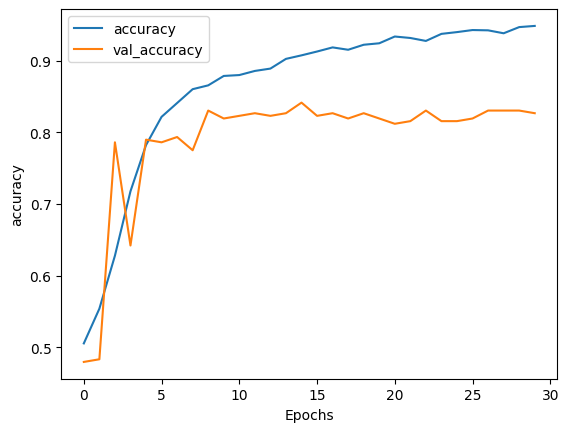

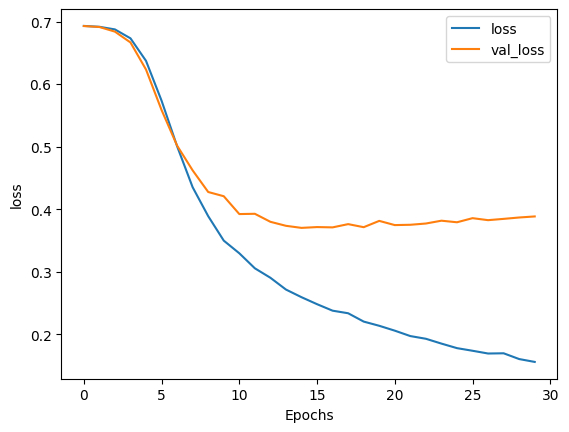

In [32]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [78]:
seed_text = "saya suka kamu"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.05920303 0.94079703]]
